# PyMC3

PyMC3 is a python module that uses

* Probabilistic Modelling
* Bayesian Statistical Modelling & Fitting
* Advanced MCMC (Markov Chain MonteCarlo) Techniques and Variational Inference Techniques



# Mathematical Setting

Using Markov-Chain MonteCarlo is possible to determine what is the posterior $p(\theta\,|\,x)$ for the parameters $\theta$ given a data sample $x$. One assumes the data sample $X$ to be distributed according to a likelihood $p(x\,|\,\theta)$

$$X\sim p(x\,|\,\theta)$$

The parameter posterior can be computed by using the Bayes's Theorem

$$p(\theta\,|\,x)=\frac{p(x\,|\,\theta)\,p(\theta)}{p(x)}$$.

__Example.__ Let's suppose that one has a test dataseet $X\sim\exp(\,\cdot\,;\,\beta)$, where $\exp$ is the (negative) exponential distribution (PDF)

$$\exp(x\,;\,\beta)=\frac{1}{\beta}e^{-x/\beta}$$

the scale parameter can be also $\lambda=1/\beta$. `numpy.random.exponential` and `scipy.stats.expon` use $\beta$, while `pymc3.Exponential` uses $\lambda$.

/home/fabio/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


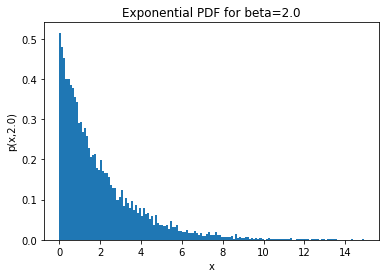

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pymc3 as pm
import pandas as pd

#np.random.seed(0)
pd.set_option("display.max_columns", 20)

# generate observations from an exponential distribution
def generate_sample(beta=1, size=1000):
	return np.random.exponential(beta, size)

# the size of the sample
size = 10000

beta = 2e0

# generate the observations
X = generate_sample(beta=beta, size=size)

plt.hist(X, bins=np.arange(0, 15, 0.1), density=True)
plt.title(f"Exponential PDF for beta={beta}")
plt.xlabel("x")
plt.ylabel(f"p(x,{beta})")
plt.show()

__PyMC3 Model.__ The PyMC3 model consists in the definition of the initial prior for the $\beta$ parameter (`prior_beta`). One can assume the prior as continuosly and uniformly distributed between two values (`pymc3.Uniform()`). Note that the value of the variable must be specified in the definition. Afterwards, one defines the likelihood with the dependence on the parameters and the availability of observation. Maximum A Posteriori estimate can be used as starting point for the Markov-Chain MonteCarlo algorithm,

In [2]:
# set a PyMC3 model
with pm.Model() as model:
    
    # the initial prior is a uniformly distributed between 0 and 10
	prior_beta = pm.Uniform('beta', lower=0, upper=10)
    
    # the likelihood is a negative exponential distribution (lambda=1/beta)
	likelihood_data = pm.Exponential('X|beta', lam=1/prior_beta, observed=X)
    
    # use Maximum A Posteriori estimate for starting the NUTS algorithm
	start = pm.find_MAP()

with model:
    # sample the posterior
	trace_v01 = pm.sample(draws=2000, chains=10, tune=1000, start=start)


logp = -20,057, ||grad|| = 3,019.9: 100%|██████████| 9/9 [00:00<00:00, 519.57it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 2 jobs)
NUTS: [beta]
Sampling 10 chains: 100%|██████████| 30000/30000 [00:23<00:00, 1251.94draws/s]



Inference Summary

          mean       sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
beta  1.980436  0.02003  0.000221  1.941896  2.020292  8498.210621  1.000034

1.9804356581590903, 0.020030368096247562, 1.941176858093365, 2.0196944582248157


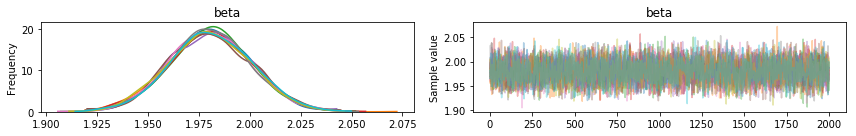

In [4]:
# print the inference summary
print("\nInference Summary\n")
print(pm.summary(trace_v01))

# explicitily compute the 2nd order statistics
# trace_v01['beta'] is an array, so standard numpy methods can be used
mean_beta = trace_v01['beta'].mean()
std_beta = trace_v01['beta'].std()
# explicit calculation of the high posterior density interval
hpd = sp.stats.norm.interval(1-0.05, loc=mean_beta, scale=std_beta)

print(f"\n{mean_beta}, {std_beta}, {hpd[0]}, {hpd[1]}")

# embedded method for graphical description
pm.traceplot(trace_v01)
plt.show()

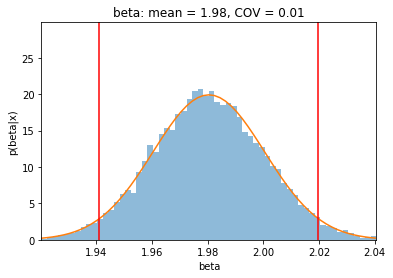

In [5]:
# manual plot of the statistics
def inclusive(a):
    return a*(1+1e-12)

x = np.arange(mean_beta-5*std_beta, inclusive(mean_beta+5*std_beta), 0.01*10*std_beta)

plt.hist(trace_v01['beta'], bins=x, density=True, alpha=0.5)
plt.plot(x, sp.stats.norm.pdf(x, loc=mean_beta, scale=std_beta))
plt.plot([hpd[0], hpd[0]], [0,1.5*1/np.sqrt(2*np.pi*std_beta**2)], color='red')
plt.plot([hpd[1], hpd[1]], [0,1.5*1/np.sqrt(2*np.pi*std_beta**2)], color='red')
plt.xlim(mean_beta-3*std_beta, mean_beta+3*std_beta)
plt.ylim(0, 1.5/np.sqrt(2*np.pi*std_beta**2))
plt.xlabel('beta')
plt.ylabel('p(beta|x)')
plt.title(f"beta: mean = {round(mean_beta, 2)}, COV = {round(std_beta/mean_beta,2)}")

plt.show()

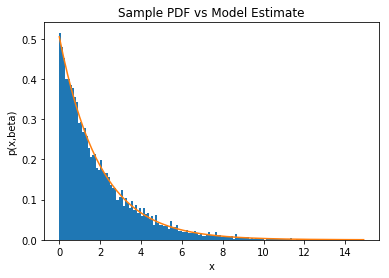

In [6]:
# compare the sample PDF with that inferred by PyPMC3 (model estimate)
x = np.arange(0, 15, 0.1)

plt.hist(X, bins=np.arange(0, 15, 0.1), density=True)
plt.plot(x, sp.stats.expon.pdf(x, loc=0, scale=mean_beta))
plt.title("Sample PDF vs Model Estimate")
plt.xlabel("x")
plt.ylabel("p(x,beta)")
plt.show()


__Example 2.__ Inference with a deterministic function for a switchpoint.

Let's suppose that one has a number of $X\sim p(x\,|\,\tau,\beta_1,\beta_2)\}$
* $p(x\,|\,t<\tau,\beta_1,\beta_2)=\exp(x\,|\,\beta_1)$
* $p(x\,|\,t>\tau,\beta_1,\beta_2)=\exp(x\,|\,\beta_2)$


In [7]:
# some imports

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt # theano for compiling the deterministic function
from theano.compile.ops import as_op
import pandas as pd # pymc3 summaries are pandas dataframes

tau = 686


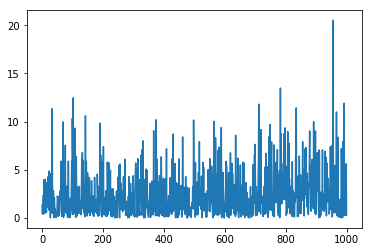

In [8]:
n = 1000
#np.random.seed(2)
def generate_data():
	tau = np.random.randint(200, 800) # when the behavior changes
	print(f"tau = {tau}") # print tau, for checking
	mu1 = 2 # first rate
	mu2 = 3 # second rate
	sample = np.zeros(n)
	sample[:tau] = np.random.exponential(mu1, tau)
	sample[tau:] = np.random.exponential(mu2, n-tau)
	return sample

data = generate_data()
plt.plot(data)
plt.show()

Multiprocess sampling (10 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>CompoundStep
>>Slice: [mu2]
>>Slice: [mu1]
Sampling 10 chains: 100%|██████████| 30000/30000 [00:40<00:00, 732.66draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


           mean         sd  mc_error     hpd_2.5    hpd_97.5        n_eff  \
tau  698.476000  40.744942  2.687081  635.000000  782.000000   184.242231   
mu1    2.154396   0.084799  0.001119    1.994251    2.327768  5876.608406   
mu2    3.077910   0.189707  0.004636    2.696925    3.442275  1541.293670   

         Rhat  
tau  1.025104  
mu1  1.000442  
mu2  1.002430  


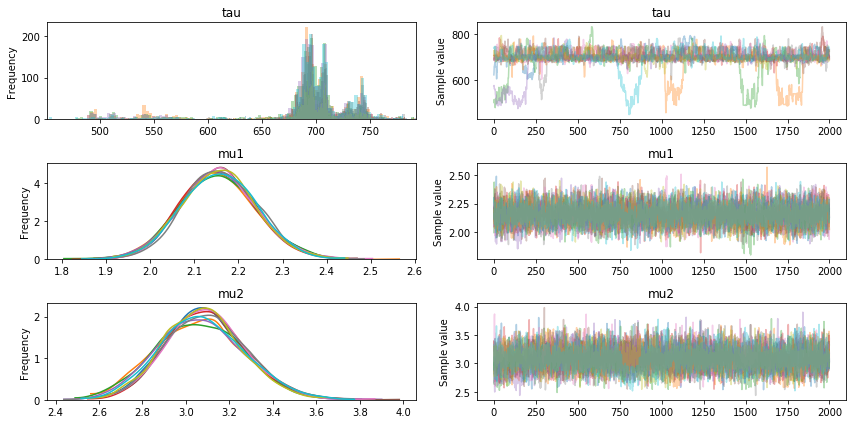

In [9]:
# the deterministic function
@as_op(itypes=[tt.lscalar, tt.dscalar, tt.dscalar], otypes=[tt.dvector])
def mu_fun(tau, mu1, mu2):
	out = np.zeros(n)
	out[:tau] = mu1
	out[tau:] = mu2
	return out

# the model
with pm.Model() as model:
	tau = pm.DiscreteUniform('tau', lower=0, upper=n)
	mu1 = pm.Uniform('mu1', lower=0, upper=10)
	mu2 = pm.Uniform('mu2', lower=0, upper=10)
	mu = mu_fun(tau, mu1, mu2)
	likelihood = pm.Exponential('likelihood', lam=1/mu, observed=data)
	#start = {'tau': 5000, 'mu1': 5., 'mu2': 5.}
	#step1 = pm.Slice([mu1, mu2])
	#step2 = pm.Metropolis([tau])


with model:
    # sample the posterior
	trace_v01 = pm.sample(draws=2000, chains=10, tune=1000)
    
# infer the parameters
#with model:
	#trace = pm.sample(10000, tune=500, start=start, step=[step1, step2], cores=8)
	#trace = pm.sample(1000, start=start, step=[step1, step2], cores=1)
#	trace = pm.sample(2000, cores=8)

# results
pm.traceplot(trace_v01)
summary = pm.summary(trace_v01)
print(summary)
summary.to_csv('summary.csv')


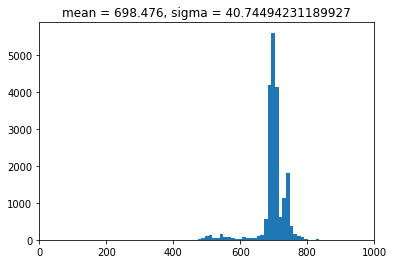

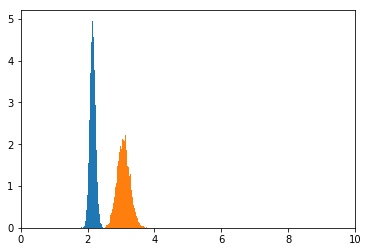

In [10]:
plt.hist(trace_v01['tau'], bins=np.arange(0,10000,11))
plt.title(f"mean = {trace_v01['tau'].mean()}, sigma = {trace_v01['tau'].std()}")
plt.xlim(0, 1000)
plt.show()

mu1_mean = trace_v01['mu1'].mean()
mu1_std = trace_v01['mu1'].std()
mu2_mean = trace_v01['mu2'].mean()
mu2_std = trace_v01['mu2'].std()

plt.hist(trace_v01['mu1'], bins=np.arange(mu1_mean-5*mu1_std, mu1_mean+5*mu1_std, 0.1*mu1_std), density=True)
plt.hist(trace_v01['mu2'], bins=np.arange(mu2_mean-5*mu2_std, mu2_mean+5*mu2_std, 0.1*mu2_std), density=True)
plt.xlim(0, 10)
plt.show()

#plt.hist(trace['mu2'])
#plt.show()